# Happy Customer
- Author: Yumo Bai
- Email: baiym104@gmail.com
- Date: Feb 26, 2023

### Load Packages and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

In [2]:
df = pd.read_csv('./data/ACME-HappinessSurvey2020.csv')

### Exploratory Data Analysis

We will start with an overview to the dataset.

In [3]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


The dataset contains 126 entries and there seem to be no missing data. The target variable is `Y`, let's take a look at it's distribution.

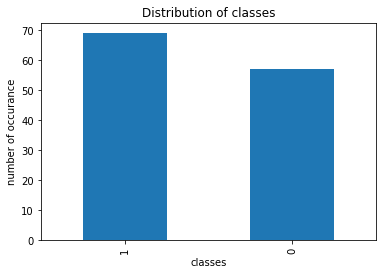

In [5]:
df['Y'].value_counts().plot(kind='bar', xlabel='classes', ylabel='number of occurance',
                            title='Distribution of classes')
plt.show()

The classes appear to be balanced. So there should be no additional cleaning and upsampling/downsampling required. Let's now take a look at the distribution of the features.

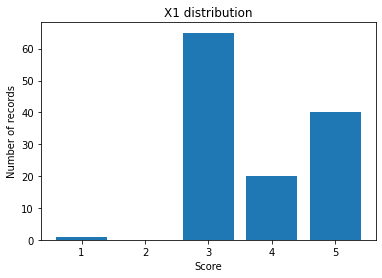

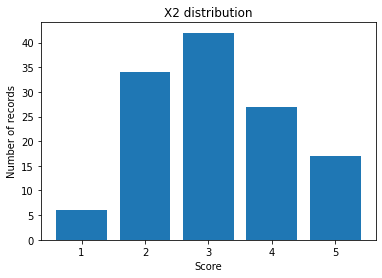

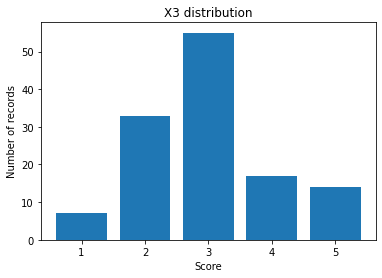

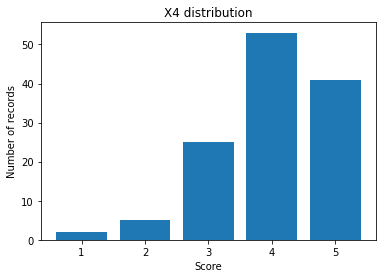

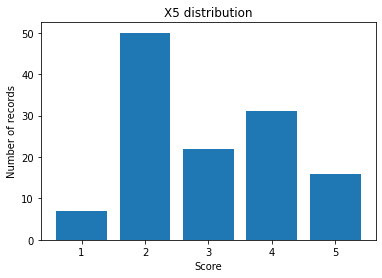

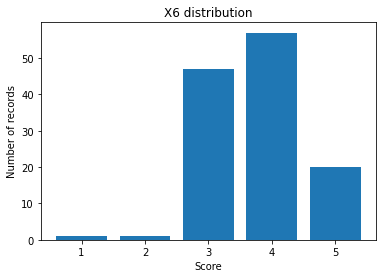

In [6]:
X = df.drop('Y', axis=1)
y = df['Y']

for column in X.columns:
    plt.figure()
    plt.bar(X[column].unique(), X[column].value_counts())
    plt.title(f'{column} distribution')
    plt.xlabel('Score')
    plt.ylabel('Number of records')
plt.show()

It seems that `X2` and `X3` follow a more normal distribution. `X1`, `X4` and `X6` are all right-skewed whereas `X5` seem to have a more random distribution. We can check if any of these features are correlated by calculating the correlation matrix.

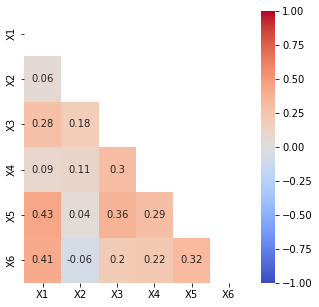

In [7]:
corr_df = X.corr()

# mask
mask = np.triu(corr_df)

# heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(corr_df.round(2), vmax=1, vmin=-1, center=0, annot=True, mask=mask, cmap='coolwarm')
plt.show()

It appears that `X1` has the highest correlation with `X5` and `X6`. However, there is not a sign of strong correlation between any of the features. So for now we will proceed to build a model with all of the features present.

### Modeling

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [9]:
logreg = LogisticRegression(random_state=22)
logreg.fit(X_train, y_train)
print(f'LR Training Accuracy:{logreg.score(X_train, y_train)}')
print(f'LR Testing Accuracy:{logreg.score(X_test, y_test)}')

LR Training Accuracy:0.55
LR Testing Accuracy:0.6923076923076923


With a simple logistic regression model, we get 55% training accuracy and 69% testing accuracy, indicating underfitting of the data. We can either increment the size of the data set which would not be feasible in this case or instead use models with higher complexity to tackle the issue.

In [10]:
svm = SVC(random_state=22)
svm.fit(X_train, y_train)
print(f'SVM Training Accuracy:{svm.score(X_train, y_train)}')
print(f'SVM Testing Accuracy:{svm.score(X_test, y_test)}')

SVM Training Accuracy:0.72
SVM Testing Accuracy:0.5769230769230769


In [11]:
dt = DecisionTreeClassifier(max_depth=4, random_state=22)
dt.fit(X_train, y_train)
print(f'DT Training Accuracy:{dt.score(X_train, y_train)}')
print(f'DT Testing Accuracy:{dt.score(X_test, y_test)}')

DT Training Accuracy:0.75
DT Testing Accuracy:0.6538461538461539


In [12]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print(f'KNN Training Accuracy:{knn.score(X_train, y_train)}')
print(f'KNN Testing Accuracy:{knn.score(X_test, y_test)}')

KNN Training Accuracy:0.7
KNN Testing Accuracy:0.6153846153846154


More complex models such as SVM, Decision Tree and KNN Classifiers give us satisfactory accuracy on the Training set. However, they seem to be overfitting the training set as their performance on the testing set is much worse. 

Noticeably, for this particular training and testing set, a KNN classifier with `n_neighbors=6` has a reasonably good performance which could just be a result of the randomization:

In [37]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
print(f'KNN Training Accuracy:{knn.score(X_train, y_train)}')
print(f'KNN Testing Accuracy:{knn.score(X_test, y_test)}')

KNN Training Accuracy:0.69
KNN Testing Accuracy:0.7307692307692307


We could also try out some ensembled models.

In [14]:
rf = RandomForestClassifier(random_state=22)
rf.fit(X_train, y_train)
print(f'RF Training Accuracy: {rf.score(X_train, y_train)}')
print(f'RF Testing Accuracy: {rf.score(X_test, y_test)}')

RF Training Accuracy: 0.94
RF Testing Accuracy: 0.6538461538461539


In [15]:
ada = AdaBoostClassifier(random_state=22)
ada.fit(X_train, y_train)
print(f'Ada Training Accuracy: {ada.score(X_train, y_train)}')
print(f'Ada Testing Accuracy: {ada.score(X_test, y_test)}')

Ada Training Accuracy: 0.67
Ada Testing Accuracy: 0.6538461538461539


In [16]:
gdb = GradientBoostingClassifier(random_state=22)
gdb.fit(X_train, y_train)
print(f'GDB Training Accuracy: {gdb.score(X_train, y_train)}')
print(f'GDB Testing Accuracy: {gdb.score(X_test, y_test)}')

GDB Training Accuracy: 0.91
GDB Testing Accuracy: 0.5


In [17]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
print(f'XGB Training Accuracy: {xgb_model.score(X_train, y_train)}')
print(f'XGB Testing Accuracy: {xgb_model.score(X_test, y_test)}')

XGB Training Accuracy: 0.93
XGB Testing Accuracy: 0.5384615384615384


Out of all the ensembled models, AdaBoostClassifier seem to be the only one with a balanced bias-variance trade-off as its training and testing accuracy are only separated by around 1.7%. Random Forest Classifier gave an over all highest score with a 94% accuracy training accuracy and 65.4% testing accuracy. However, this also indicates that the model is significantly overfitting the training data. We could further improve the model by tuning its hyperparameters with the cross-validation method.

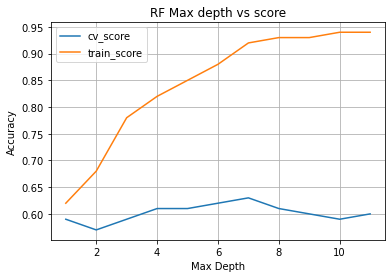

In [18]:
depths = np.arange(1,12)
cv_scores = []
training_scores = []

for depth in depths:
    rf = RandomForestClassifier(max_depth=depth, random_state=22)
    cv_scores.append(np.mean(cross_val_score(rf, X_train, y_train, cv=5)))
    rf.fit(X_train, y_train)
    training_scores.append(rf.score(X_train, y_train))
    
plt.figure()
plt.plot(depths, cv_scores, label='cv_score')
plt.plot(depths, training_scores, label='train_score')
plt.title('RF Max depth vs score')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

The model minimizes the gap between training and testing score with max depth of 4. Similarly, we could also change the `n_estimator` and `min_sample_leaf`.

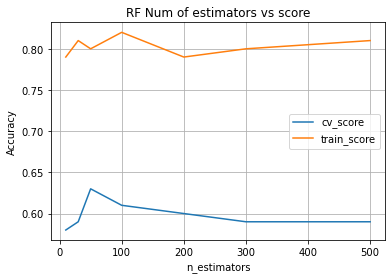

In [19]:
ns = [10,30,50,100,200,300,500]
cv_scores = []
training_scores = []

for n in ns:
    rf = RandomForestClassifier(n_estimators=n, max_depth=4, random_state=22)
    cv_scores.append(np.mean(cross_val_score(rf, X_train, y_train, cv=5)))
    rf.fit(X_train, y_train)
    training_scores.append(rf.score(X_train, y_train))
    
plt.figure()
plt.plot(ns, cv_scores, label='cv_score')
plt.plot(ns, training_scores, label='train_score')
plt.title('RF Num of estimators vs score')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

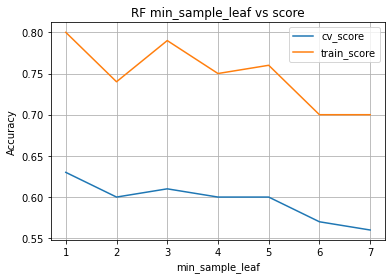

In [20]:
msls = np.arange(1,8)
cv_scores = []
training_scores = []

for msl in msls:
    rf = RandomForestClassifier(n_estimators=50, max_depth=4, min_samples_leaf=msl,
                                random_state=22)
    cv_scores.append(np.mean(cross_val_score(rf, X_train, y_train, cv=5)))
    rf.fit(X_train, y_train)
    training_scores.append(rf.score(X_train, y_train))
    
plt.figure()
plt.plot(msls, cv_scores, label='cv_score')
plt.plot(msls, training_scores, label='train_score')
plt.title('RF min_sample_leaf vs score')
plt.xlabel('min_sample_leaf')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

And we examine the model with the tuned parameters.

In [21]:
rf = RandomForestClassifier(n_estimators=50, max_depth=4, min_samples_leaf=1,
                        random_state=22)
rf.fit(X_train, y_train)
print(f'Tuned RF Training Accuracy: {rf.score(X_train, y_train)}')
print(f'Tuned RF Testing Accuracy: {rf.score(X_test, y_test)}')

Tuned RF Training Accuracy: 0.8
Tuned RF Testing Accuracy: 0.7307692307692307


The tuned RF model gives 80% training accuracy and 73.07% testing accuracy. Which is still overfitting the training data slightly. If we increase the `min_samples_leaf` to reduce the overfitting, we actually see a testing accuracy of 73.07% with `min_samples_leaf=2` with much lower training accuracy at 74%.

In [22]:
rf = RandomForestClassifier(n_estimators=50, max_depth=4, min_samples_leaf=2,
                        random_state=22)
rf.fit(X_train, y_train)
print(f'Tuned RF Training Accuracy: {rf.score(X_train, y_train)}')
print(f'Tuned RF Testing Accuracy: {rf.score(X_test, y_test)}')

Tuned RF Training Accuracy: 0.74
Tuned RF Testing Accuracy: 0.7307692307692307


It looks like a huge improvement from the model that we came up with. However, we cannot be sure that this model is better as the dataset is small and it could just be a result of randomization.

XGBoost also performed excellently on the training set, using the same methodology, we can see if it is possible to get a better model by tuning its hyperparameters.

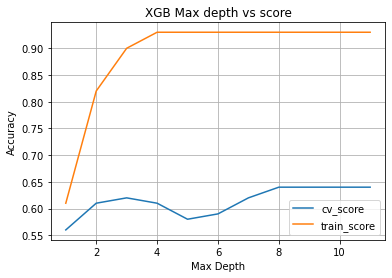

In [23]:
depths = np.arange(1,12)
cv_scores = []
training_scores = []

for depth in depths:
    xgb_model = xgb.XGBClassifier(max_depth=depth, random_state=22)
    cv_scores.append(np.mean(cross_val_score(xgb_model, X_train, y_train, cv=5)))
    xgb_model.fit(X_train, y_train)
    training_scores.append(xgb_model.score(X_train, y_train))
    
plt.figure()
plt.plot(depths, cv_scores, label='cv_score')
plt.plot(depths, training_scores, label='train_score')
plt.title('XGB Max depth vs score')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

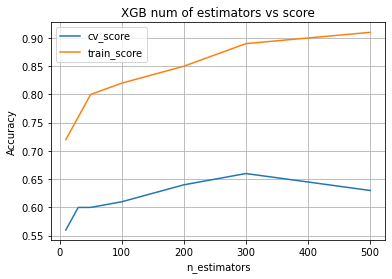

In [24]:
ns = [10,30,50,100,200,300,500]
cv_scores = []
training_scores = []

for n in ns:
    xgb_model = xgb.XGBClassifier(n_estimators=n, max_depth=2, random_state=22)
    cv_scores.append(np.mean(cross_val_score(xgb_model, X_train, y_train, cv=5)))
    xgb_model.fit(X_train, y_train)
    training_scores.append(xgb_model.score(X_train, y_train))
    
plt.figure()
plt.plot(ns, cv_scores, label='cv_score')
plt.plot(ns, training_scores, label='train_score')
plt.title('XGB num of estimators vs score')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

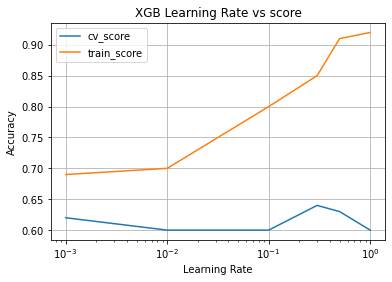

In [25]:
# We tune the learning rate instead of min_samples_leaf for XGBoost
lrs = [0.001, 0.01, 0.1, 0.3, 0.5, 1]
cv_scores = []
training_scores = []

for lr in lrs:
    xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=2, 
                                  learning_rate=lr,
                                  random_state=22)
    cv_scores.append(np.mean(cross_val_score(xgb_model, X_train, y_train, cv=5)))
    xgb_model.fit(X_train, y_train)
    training_scores.append(xgb_model.score(X_train, y_train))
    
plt.figure()
plt.plot(lrs, cv_scores, label='cv_score')
plt.plot(lrs, training_scores, label='train_score')
plt.title('XGB Learning Rate vs score')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

In [26]:
xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=2, 
                                  learning_rate=0.3,
                                  random_state=22)
xgb_model.fit(X_train, y_train)
print(f'Tuned XGB Training Accuracy: {xgb_model.score(X_train, y_train)}')
print(f'Tuned XGB Testing Accuracy: {xgb_model.score(X_test, y_test)}')

Tuned XGB Training Accuracy: 0.85
Tuned XGB Testing Accuracy: 0.5384615384615384


Despite tuning, We could not reduce the overfitting issue with XGBoost as the final model has 85% accuracy on the training set but only 54% on the testing set. So we will finalize our model with the tuned Random Forest Classifier.

We can now move on the analyzing the importance of the features.

### Feature Selection

From the correlation matrix that we calculated earlier, we see that `X1` has a relatively higher correlation with both `X5` and `X6`, how would it affect our model if we remove it from the features? 

In [50]:
# Remove X1 from the dataset
X_5_feature = X.drop(['X1'], axis=1)
X_train_5_feature, X_test_5_feature, y_train, y_test = train_test_split(X_5_feature,
                                                y, test_size=0.2, random_state=40)

# Reinstantiate and train a 5-feature RF model on the new dataset
rf_5_feature = RandomForestClassifier(n_estimators=50, max_depth=4, min_samples_leaf=1,
                        random_state=22)
rf_5_feature.fit(X_train_5_feature, y_train)
print(f'Training Accuracy: {rf_5_feature.score(X_train_5_feature, y_train)}')
print(f'Testing Accuracy: {rf_5_feature.score(X_test_5_feature, y_test)}')

Training Accuracy: 0.75
Testing Accuracy: 0.5769230769230769


The training accuracy of the model dropped from 80% to 75% whereas the testing accuracy dropped significantly from 73.07% to 57.7%. As we removed a feature from the dataset, the model with the same level of complexity would tend to overfit the training set, so we should also simplify the model a bit.

In [61]:
rf_5_feature = RandomForestClassifier(n_estimators=50, max_depth=3, min_samples_leaf=2,
                        random_state=22)
rf_5_feature.fit(X_train_5_feature, y_train)
print(f'Training Accuracy: {rf_5_feature.score(X_train_5_feature, y_train)}')
print(f'Testing Accuracy: {rf_5_feature.score(X_test_5_feature, y_test)}')

Training Accuracy: 0.68
Testing Accuracy: 0.6538461538461539


Even as we do so, the accuracy still suffers quite a bit as the best testing accuracy we could achieve is around 65%. So it seems that `X1` cannot be removed.

Instead, we could utilize the `feature_importance_` attribute of our previous model to see what features does it consider to be less important.

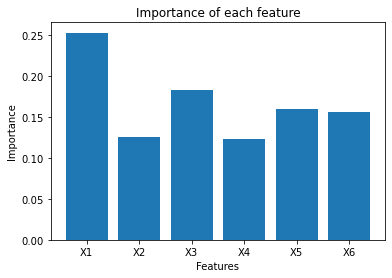

In [62]:
# Plot the feature importance of the tuned RF model
plt.figure()
plt.bar(X.columns, rf.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Importance of each feature')
plt.show()

The two features with lowest importance are `X2` and `X4`. We can try removing them from the training and see how does the performance change.

In [38]:
# Remove X2, X4 from the dataset
X_4_feature = X.drop(['X2', 'X4'], axis=1)
X_train_4_feature, X_test_4_feature, y_train, y_test = train_test_split(X_4_feature,
                                                y, test_size=0.2, random_state=40)

# Reinstantiate and train a 5-feature RF model on the new dataset
rf_4_feature = RandomForestClassifier(n_estimators=50, max_depth=4, min_samples_leaf=1,
                        random_state=22)
rf_4_feature.fit(X_train_4_feature, y_train)
print(f'Training Accuracy: {rf_4_feature.score(X_train_4_feature, y_train)}')
print(f'Testing Accuracy: {rf_4_feature.score(X_test_4_feature, y_test)}')

Training Accuracy: 0.84
Testing Accuracy: 0.5384615384615384


After dropping off the least important features, the model starts to overfit the training data again and the performance on the testset drops significantly. However, what if we switch back to the simple logistic regression model?

In [47]:
rf_4_feature = RandomForestClassifier(n_estimators=70, max_depth=2, min_samples_leaf=1,
                        random_state=22)
rf_4_feature.fit(X_train_4_feature, y_train)
print(f'Training Accuracy: {rf_4_feature.score(X_train_4_feature, y_train)}')
print(f'Testing Accuracy: {rf_4_feature.score(X_test_4_feature, y_test)}')

Training Accuracy: 0.71
Testing Accuracy: 0.6923076923076923


With some tuning, the 4-feature Random Forest Classifier was able to achieve 71% Training Accuracy and 69.23% Testing Accuracy. Which is only about 4% lower comparing to the model using the full features.

It seems that we could potentially remove `X2` and `X4` in the next survey. Which makes sense since customer are most likely to have purchased the product acknowledging what is to expect and the price of the item.